# Step 2: Digitize the simulated data

In [1]:
distances = [15, 35]
doubleplanes = [8, 12, 20, 30]
energies = [200, 600, 1000]
erels = [100, 500, 1000, 2000, 3000]
neutrons = [1, 2, 3, 4, 5, 6]
physicss = ["bert", "bic", "inclxx"]

## a) Digitize

In [2]:
import joblib
from digitization import digitization

joblib.Parallel(n_jobs=-1, backend="loky", verbose=1)(
    joblib.delayed(digitization)(
        distance=distance,
        doubleplane=doubleplane,
        energy=energy,
        erel=erel,
        neutron=neutron,
        physics=physics,
    )
    for distance in distances
    for energy in energies
    for doubleplane in doubleplanes
    for neutron in neutrons
    for erel in erels
    for physics in physicss
);

Welcome to JupyROOT 6.16/00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 36.9min finished


## b) Check digitization: Number of events

In [3]:
import pandas as pd
import numpy as np
import joblib
import os
import ROOT
from helpers import filename_for

ROOT.ROOT.EnableThreadSafety()

In [4]:
def processed_events(distance, doubleplane, energy, erel, neutron, physics):
    filename = filename_for(
        distance, doubleplane, energy, erel, neutron, physics, ".digi.root"
    )
    if os.path.isfile(filename):
        try:
            tfile = ROOT.TFile.Open(filename)
            ttree = tfile.Get("evt")
            num_events = int(ttree.GetEntries())
            return (filename, num_events)
        except:
            pass
    return (filename, 0)

In [5]:
evts = pd.DataFrame(
    joblib.Parallel(n_jobs=-1, backend="multiprocessing", verbose=1)(
        joblib.delayed(processed_events)(
            distance=distance,
            doubleplane=doubleplane,
            energy=energy,
            erel=erel,
            neutron=neutron,
            physics=physics,
        )
        for distance in distances
        for energy in energies
        for doubleplane in doubleplanes
        for neutron in neutrons
        for erel in erels
        for physics in physicss
    )
)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   21.9s finished


In [6]:
pd.options.display.max_rows = 5
evts.columns = ["File", "Events"]
evts.sort_values(by=["Events", "File"], ascending=[True, True], inplace=True)
evts.style.hide_index().format({"Events": "{:d}"})
display(evts)

,File,Events
816,output/bert/15m_12dp_1000AMeV_1000keV_1n.digi....,10000
831,output/bert/15m_12dp_1000AMeV_1000keV_2n.digi....,10000
...,...,...
1505,output/inclxx/35m_8dp_600AMeV_500keV_5n.digi.root,10000
1520,output/inclxx/35m_8dp_600AMeV_500keV_6n.digi.root,10000


## c) Check digitization: Histrograms for sample file

In [7]:
def digidata(distance, doubleplane, energy, erel, nmax, physics):
    t = []
    for neutron in range(1, nmax + 1):
        filename = filename_for(
            distance, doubleplane, energy, erel, neutron, physics, ".digi.root"
        )
        tfile = ROOT.TFile.Open(filename)
        ttree = tfile.Get("evt")
        for event in ttree:
            # nPN: Number of incoming primary neutrons
            nIn = neutron
            # nPP: Number of primary neutrons with an energy deposition in NeuLAND
            nPP = event.NeulandPrimaryPoints.GetEntries()
            # nPH: Number of hits that correspond to a energy deposition of a primary neutron
            nPH = event.NeulandPrimaryHits.GetEntries()
            # nHits: Number of hits
            num_hits = event.NeulandHits.GetEntries()
            # nClus: Number of clusters
            num_clusters = event.NeulandClusters.GetEntries()
            # Edep: Total deposited (detected) energy
            # FIXME: why are there nans !?
            edep = round(sum([np.nan_to_num(hit.GetE()) for hit in event.NeulandHits]))

            t.append([nIn, nPP, nPH, num_hits, num_clusters, edep])

    df = pd.DataFrame(t)
    df.columns = ["nIn", "nPP", "nPH", "num_hits", "num_cluster", "edep"]
    return df

In [8]:
data = digidata(
    distance=15, doubleplane=30, energy=600, erel=500, nmax=6, physics="inclxx",
)

In [9]:
pd.options.display.max_rows = 5
data.style.hide_index()
display(data)

,nIn,nPP,nPH,num_hits,num_cluster,edep
0,1,1,1,8,2,203.0
1,1,1,1,12,1,320.0
...,...,...,...,...,...,...
59998,6,6,6,89,31,1769.0
59999,6,6,6,53,26,1275.0


In [10]:
nmax = 6
hits = [
    np.histogram(
        data[data["nPH"] == n]["num_hits"], range=(0, 150), bins=150, density=True
    )[0]
    for n in range(1, nmax + 1)
]
clus = [
    np.histogram(
        data[data["nPH"] == n]["num_cluster"], range=(0, 75), bins=75, density=True
    )[0]
    for n in range(1, nmax + 1)
]
edep = [
    np.histogram(
        data[data["nPH"] == n]["edep"], range=(0, 3000), bins=150, density=True
    )[0]
    for n in range(1, nmax + 1)
]

Using matplotlib backend: agg


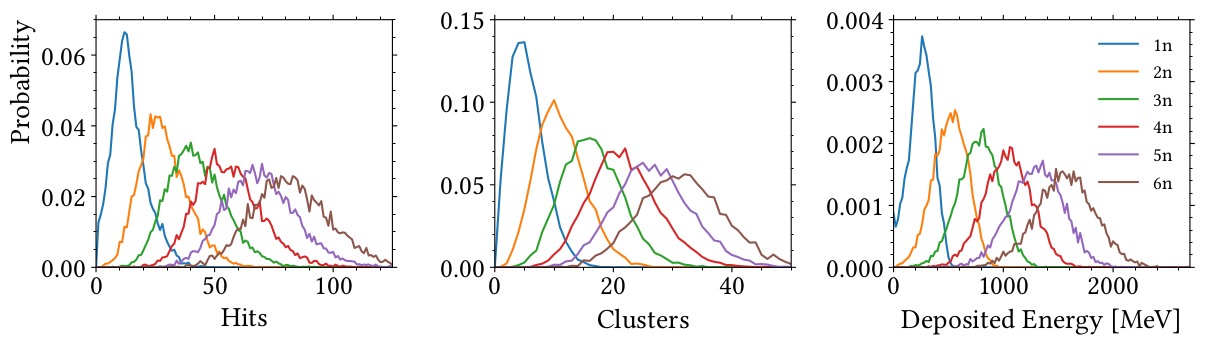

In [11]:
%matplotlib

from plotconfroot import *

fig = plt.figure(figsize=(2 * 6.224, 6.224 / 1.618))

ax1 = fig.add_subplot(131)
ax1.set_xlim(0, 125)
ax1.set_ylim(0, 0.07)
for h in hits:
    ax1.plot(h)
ax1.set_ylabel(r"Probability", horizontalalignment="right", y=1)
ax1.set_xlabel(r"Hits")

ax2 = fig.add_subplot(132)
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 0.15)
for c in clus:
    ax2.plot(c)
ax2.set_xlabel(r"Clusters")

xs = np.arange(0, 3000, 3000 / 150)
ax3 = fig.add_subplot(133)
ax3.set_xlim(0, 2700)
ax3.set_ylim(0, 0.004)
for i, e in enumerate(edep, 1):
    ax3.plot(xs, e, label=f"{i}n")
ax3.set_xlabel(r"Deposited Energy [MeV]")

ax3.legend(prop={"size": "x-small"})

fig.tight_layout()
fig.savefig(f"paper/basic_distributions.pdf", bbox_inches="tight")
display(fig)

In [12]:
pd.options.display.max_rows = 7
display(data.groupby("nPH").mean())

,nIn,nPP,num_hits,num_cluster,edep
nPH,,,,,
0,1.070270,0.392793,0.005405,0.001802,0.151351
1,1.098964,1.033755,14.162927,5.509014,260.737150
2,2.152021,2.051623,28.564339,11.150123,524.426741
3,3.205835,3.067443,42.463484,16.516719,786.974235
4,4.244677,4.078266,55.962018,21.766162,1048.484462
5,5.220236,5.070316,69.418897,26.747603,1310.367259
6,6.000000,6.000000,82.332710,31.630679,1569.788081


In [13]:
data200 = digidata(
    distance=15, doubleplane=30, energy=200, erel=500, nmax=6, physics="inclxx",
)
display(data200.groupby("nPH").mean())

,nIn,nPP,num_hits,num_cluster,edep
nPH,,,,,
0,1.066116,0.458678,0.000000,0.000000,0.000000
1,1.146955,1.055318,4.400820,2.850438,76.685789
2,2.213387,2.082332,9.077826,5.928934,155.304638
3,3.270735,3.101373,13.660993,8.941979,233.093568
4,4.326523,4.121175,18.281424,11.996234,310.296300
5,5.270268,5.102024,22.867257,15.009562,388.295087
6,6.000000,6.000000,27.394528,17.929832,465.548838


In [14]:
data1000 = digidata(
    distance=15, doubleplane=30, energy=1000, erel=500, nmax=6, physics="inclxx",
)
display(data1000.groupby("nPH").mean())

,nIn,nPP,num_hits,num_cluster,edep
nPH,,,,,
0,1.044944,0.337079,0.285393,0.031461,5.047191
1,1.084908,1.028878,27.894656,8.268541,482.240430
2,2.127357,2.038188,53.797711,16.234225,939.157561
3,3.164130,3.046523,78.931901,23.835388,1399.815065
4,4.196304,4.056018,102.879741,30.949303,1852.127612
5,5.184119,5.052903,127.022333,38.022333,2316.720695
6,6.000000,6.000000,149.876495,44.745562,2775.171849


## d) Check input: Erel from simulation

Workaround for jupyter lab until up-to-date ROOT version is in FairRoot

In [15]:
%%javascript
var s = document.createElement('script');
s.src='https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js';
document.body.appendChild(s);

<IPython.core.display.Javascript object>

In [16]:
distance = 15
doubleplane = 30
energy = 600
erel = 500
neutron = 6
physics = "inclxx"

In [17]:
%jsroot on
tfile = ROOT.TFile.Open(
    filename_for(distance, doubleplane, energy, erel, neutron, physics, ".digi.root")
)
c = ROOT.TCanvas("cv", "cv", 800, 600)
h = tfile.Get("NeulandMCMon/hErelMC")
h.Draw()
c.Draw()